# 問題
厚さ$d$，透磁率$\mu_0$の不均質誘電体スラブにパルス平面波が入射する場合を考える．

![](img/1D.png)

# 環境構築

In [81]:
%pip install numpy
import numpy as np

%pip install matplotlib
import matplotlib.pyplot as plt

%pip install tqdm
from tqdm import tqdm 

%mkdir result
%rm result/*.png

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
mkdir: cannot create directory ‘result’: File exists


# 各種パラメータの設定

In [82]:
# 解析のパラメータ
nz    = 1000 # 解析領域の分割数
nstep = 2000 # 計算のステップ数

# 真空のパラメータ
c    = 2.9979246e8   # 光速
esp0 = 8.8541878e-12 # 真空の誘電率
mu0  = 1.2566371e-6  # 真空の透磁率
z0   = 376.73031     # 真空の特性インピーダンス

# 誘電体のパラメータ
espr = 3.0   # 誘電体の比誘電率
d    = 0.1   # 誘電体厚さ[m]
nd   = 50    # 誘電体の分割数
kd   = nz/2  # 誘電体の左端の位置

# 解析のパラメータ
dz = d/nd # セルサイズ
dt = dz/c  # 時間ステップ

# 初期化

In [83]:
# 誘電率, 伝導率の初期化
espd = np.empty(nz) # 比誘電率
sgmd = np.empty(nz) # 伝導率

for k in range(nz):
    if k < kd or k >= kd+nd: # 真空中
        espd[k] = 1.0
        sgmd[k] = 0.0
    else: # 誘電体中
        espd[k] = espr
        sgmd[k] = 0.0

# 電界，磁界の係数
ae = np.empty(nz)
be = np.empty(nz)

for k in range(nz):
    esp = esp0*(espd[k] + espd[k-1])/2
    sgm = (sgmd[k] + sgmd[k-1])/2
    b = dt / esp
    a0 = sgm * b / 2

    ae[k] = (1 - a0)/(1 + a0)
    be[k] = b/(1 + a0)/dz

bm = dt / mu0 / dz

入射波形の関数

In [84]:
def input_pulse(z, t):
    zp = 100 * dz
    a  =  20 * dz
    return np.exp(-((z - zp - c*t)/a)**2)

初期化の続き

In [85]:
# 電界，磁界の初期化
ex = np.empty(nz)
hy = np.empty(nz)

ex_t = np.zeros(nstep) # 電界の時間応答

for k in range(nz):
    z = k*dz
    ex[k] = input_pulse(z, 0)

    z += dz/2
    hy[k] = input_pulse(z, dt/2)/z0

# 吸収境界上の電界
exlold = ex[1]
exrold = ex[nz-1]

# Murの係数
v = c/np.sqrt(espd[0])
czl = (v*dt - dz)/(v*dt + dz) # 左端

v = c/np.sqrt(espd[nz-1])
czr = (v*dt - dz)/(v*dt + dz) # 右端

電磁界分布の可視化

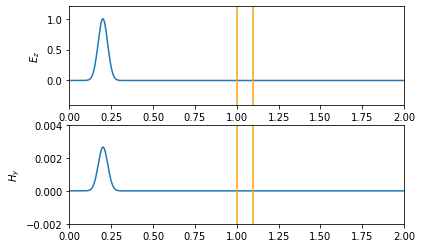

In [86]:
def plot(t, show=False):
    plt.figure(figsize=(6,4))
    plt.subplot(211)
    z = np.linspace(0, nz*dz, nz)
    plt.plot(z, ex)
    plt.plot([dz*kd,dz*kd]    , [-1.2,1.2], color="orange")
    plt.plot([dz*kd+d,dz*kd+d], [-1.2,1.2], color="orange")
    plt.ylabel(r'$E_z$')
    plt.xlim(0, dz*nz)
    plt.ylim(-0.4, 1.2)

    plt.subplot(212)
    z = np.linspace(dz/2, nz*dz, nz)
    plt.plot(z, hy)
    plt.plot([dz*kd,dz*kd]    , [-0.02,0.02], color="orange")
    plt.plot([dz*kd+d,dz*kd+d], [-0.02,0.02], color="orange")
    plt.ylabel(r'$H_y$')
    plt.xlim(0, dz*nz)
    plt.ylim(-0.002, 0.004)

    plt.savefig("result/{}.png".format(t))
    if show:
        plt.show()
    plt.close()

plot(1, True)

# 電磁界の計算 と Murの一次吸収条件

In [87]:
def e_cal():
    for k in range(1, nz-1):
        ex[k] = ae[k]*ex[k] - be[k]*(hy[k] - hy[k-1])

def h_cal():
    for k in range(0, nz-1):
        hy[k] = hy[k] - bm*(ex[k+1] - ex[k])

def mur():
    global exlold
    global exrold
    
    ex[0]  = exlold + czl*(ex[1]      - ex[0] ) # 左端
    ex[nz-1] = exrold + czr*(ex[nz-2] - ex[nz-1]) # 右端

    exlold = ex[1]
    exrold = ex[nz-2]

# FDTDの計算

In [88]:
# FDTDの計算
t = dt
for n in tqdm(range(1, nstep)):
    e_cal()
    mur()
    t += dt/2

    h_cal()
    t += dt/2
    
    ex_t[n] = ex[350]

    if n%5 == 0:
        plot(n)


100%|██████████| 1999/1999 [00:49<00:00, 40.58it/s]


# 計算結果
電磁界分布のアニメーション

In [89]:
%pip install Pillow
%pip install natsort

from PIL import Image
import glob
from natsort import natsorted


files = natsorted(sorted(glob.glob('result/*.png')))

images = list(map(lambda file: Image.open(file), files))

images[0].save('img/1D.gif', save_all=True, optimize=False, append_images=images[1:], duration=1, loop=0)


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


電界の時間応答

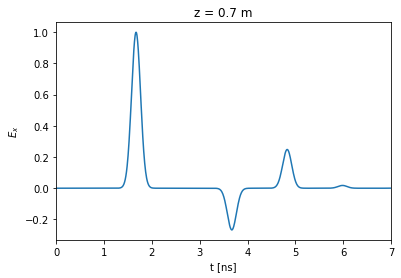

In [90]:
t = np.linspace(0, nstep*dt * 1e9, nstep)
plt.plot(t, ex_t)
plt.xlim(0, 7)
plt.title(r"z = {:.4g} m".format(350*dz))
plt.xlabel("t [ns]")
plt.ylabel(r"$E_x$")
plt.savefig("img/1D-time-domain.png")
plt.show()

t=2.5 ns 前後で，入射波と反射波に分かれる

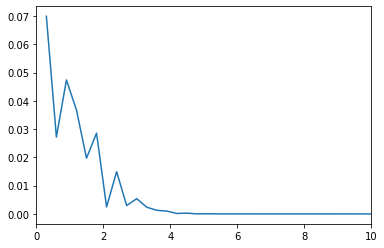

In [105]:
ex_in  = ex_t[:450]
ex_ref = ex_t[450:850]

N = 500

F = np.fft.fft(ex_ref)
freq = np.fft.fftfreq(N, d=dt) / 1e9
amp = np.abs(F/(N/2))

plt.plot(freq[1:int(N/2)], amp[1:int(N/2)])
plt.xlim(0,10)
plt.show()
